# Outlier Detection

In this section, we will check how we can deal with outliers. There are several methods that one can use to either detect the examples that are outliers and eliminate them or minimize their influence in the model. Let us start with the naive analysis of the dirty dataset.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# load the dataset
data = pd.read_csv('data/house-prices.csv',index_col=0).drop(columns = ['SellerName'])
# most naive treatment (encoding the categoricals)
data_ohe = pd.get_dummies(data,drop_first=True)

# split into input and output elements
X, y = data_ohe.drop(columns=['SalePrice']), data['SalePrice']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 20.643


# Outlier Detection: Elimination

## Isolation Forest


The Isolation Forest is a tree-based anomaly detection algorithm. It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space. Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

In [5]:
from sklearn.ensemble import IsolationForest

# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train_iso, y_train_iso = X_train[mask], y_train[mask]

# summarize the shape of the updated training dataset
print(X_train_iso.shape, y_train_iso.shape)

# fit the model
model = LinearRegression()
model.fit(X_train_iso, y_train_iso)
# evaluate the model
y_iso = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_iso)
print('MAE: %.3f' % mae)

(978, 189) (978,)
(880, 189) (880,)
MAE: 18.762


/home/rober/projects/EDIT-DSBA/machine-learning/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


As we can see, we have improved from 20.643 to 18.582 due to reducing the data from 978 to 880 examples.

## Minimum Covariance Determinant

If the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers. For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.

This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the Minimum Covariance Determinant, or MCD for short.

The scikit-learn library provides access to this method via the EllipticEnvelope class. It provides the “contamination” argument that defines the expected ratio of outliers to be observed in practice. In this case, we will set it to a value of 0.01, found with a little trial and error.

In [61]:
from sklearn.covariance import EllipticEnvelope

# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)

# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train_ee, y_train_ee = X_train[mask], y_train[mask]

# summarize the shape of the updated training dataset
print(X_train_ee.shape, y_train_ee.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_ee, y_train_ee)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(978, 189) (978,)


/home/rober/.local/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


(968, 189) (968,)
MAE: 20.937


Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome. We see however, that we are even losing precision. This is reasonable given that we are assuming that our features are distributed as gaussians, while we have performed a one-hot encoder for a reasonable amount of features...

## Local Outlier Factor

A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space. This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

The model provides the “contamination” argument, that is the expected percentage of outliers in the dataset, be indicated and defaults to 0.1.

In [63]:
from sklearn.neighbors import LocalOutlierFactor

print(X_train.shape, y_train.shape)

# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train_lof, y_train_lof = X_train[mask], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train_lof.shape, y_train_lof.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_lof, y_train_lof)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(978, 189) (978,)
(943, 189) (943,)
MAE: 19.576


## One-Class SVM

The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification. When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM.

Although SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.

The scikit-learn library provides an implementation of one-class SVM in the OneClassSVM class.

The class provides the “nu” argument that specifies the approximate ratio of outliers in the dataset, which defaults to 0.1.

In [80]:
from sklearn.svm import OneClassSVM

# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)

# identify outliers in the training dataset
ocsvm = OneClassSVM(nu=0.05)
yhat = ocsvm.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train_ocsvm, y_train_ocsvm = X_train[mask], y_train[mask]

# summarize the shape of the updated training dataset
print(X_train_ocsvm.shape, y_train_ocsvm.shape)

# fit the model
model = LinearRegression()
model.fit(X_train_ocsvm, y_train_ocsvm)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(978, 189) (978,)
(930, 189) (930,)
MAE: 18.284


## Cook's distance

Essentially Cook’s distance measures how much all of the fitted values in the model change when the ith observation is deleted. The larger the value for Cook’s distance, the more influential a given observation.

A general rule of thumb is that any observation with a Cook’s distance greater than $\frac4n$ (where $n =$ total observations) is considered to be highly influential.

In [85]:
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
model = OLS(y, X.assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     79.33
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        17:41:14   Log-Likelihood:                -6609.6
No. Observations:                1460   AIC:                         1.359e+04
Df Residuals:                    1273   BIC:                         1.458e+04
Df Model:                         186                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               -0.00

Here, we can see the most influential data point on the regression line which is basically a singular point having the highest power to control the model.

In [106]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal
print(sresiduals.idxmin(), sresiduals.min())

outlier = X.loc[sresiduals.idxmin(), :]
print('SalePrice', y.loc[sresiduals.idxmin()])
display(data.loc[sresiduals.idxmin()])

524 -10.83788956017457
SalePrice 184.75


/home/rober/.local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


MSSubClass            60
MSZoning              RL
LotArea            40094
Street              Pave
LotShape             IR1
                  ...   
YrSold              2007
SaleType             New
SaleCondition    Partial
SalePrice         184.75
SellerAge             20
Name: 524, Length: 62, dtype: object

Id
12      0.004248
31      0.004624
67      0.005699
89      0.006328
94      0.004928
          ...   
1324    0.004119
1325    0.011586
1360    0.005322
1387    0.015460
1388    0.024807
Length: 105, dtype: float64

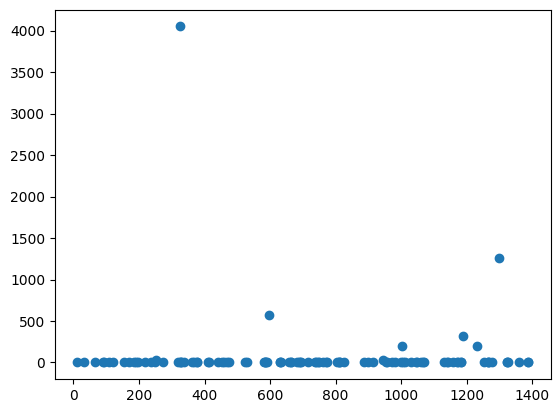

In [134]:
import matplotlib.pyplot as plt
# filter the relevant points using the 4/n rule of thumb
possible_outliers = influence.cooks_distance[0][influence.cooks_distance[0] > 4/len(data)]
display(possible_outliers)
plt.scatter(possible_outliers.index,possible_outliers)

In [159]:
import numpy as np

cook_outliers_mask = influence.cooks_distance[0].mask(influence.cooks_distance[0] > 4/len(data), -1)
cook_mask = cook_outliers_mask != -1

print(X_train.shape, y_train.shape)

# select all rows that are not outliers
X_train_cook, y_train_cook = X_train[cook_mask], y_train[cook_mask]

# summarize the shape of the updated training dataset
print(X_train_cook.shape, y_train_cook.shape)

# fit the model
model = LinearRegression()
model.fit(X_train_cook, y_train_cook)
# evaluate the model
y_cook = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_cook)
print('MAE: %.3f' % mae)

(978, 189) (978,)
(915, 189) (915,)
MAE: 17.015


/home/rober/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


# $Z$-Score

$Z$-score is an important concept in statistics. It is also called standard score. This score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data point is from the mean.

It is standard to choose around 3 standard deviations to decide to remove a value. Don't forget that this model relies on assuming that the data is distributed as a Gaussian. In this case, we have taken a brute approach and we have chosen 6 standard deviations in ANY of the features. 

In [180]:
from scipy.stats import zscore

zscore_series = pd.DataFrame(data = abs(zscore(X)), index = X.index).max(axis=1)
zscore_outliers_mask = zscore_series.mask(zscore_series > 6, -1)
zscore_mask = zscore_outliers_mask != -1
zscore_mask

print(X_train.shape, y_train.shape)

# select all rows that are not outliers
X_train_zscore, y_train_zscore = X_train[zscore_mask], y_train[zscore_mask]

# summarize the shape of the updated training dataset
print(X_train_zscore.shape, y_train_zscore.shape)

# fit the model
model = LinearRegression()
model.fit(X_train_zscore, y_train_zscore)
# evaluate the model
y_zscore = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_zscore)
print('MAE: %.3f' % mae)

(978, 189) (978,)
(541, 189) (541,)
MAE: 22.238


/home/rober/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


## Winsorize



In [23]:
from scipy.stats.mstats import winsorize
import numpy as np
X_train_win = [winsorize(X[col], limits=[0.05,0.05]) for col in X.columns.to_list()]
X_train_win = pd.DataFrame(np.transpose(X_train_win),columns=X.columns.to_list())
y_train_win = winsorize(y)
model = LinearRegression()

model.fit(X_train_win, y_train_win)
# evaluate the model
y_win = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_win)
print('MAE: %.3f' % mae)



MAE: 19.756
